In [1]:
from data_loader import DataGenerator
from datetime import datetime
from model import cnn_builder
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau,
                                        ModelCheckpoint, TensorBoard)
from tensorflow.keras.models import load_model
from tensorflow.keras.backend import clear_session
import numpy as np
import warnings
from config import (model_config, data_generator_config, load_from_file,
                    n_epochs, model_name, tb_logs_path, model_checkpoint_file, test_seq_path)
from tensorflow.keras.losses import MSE, MAE
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score
from matplotlib import pyplot as plt
from tqdm import tqdm
np.set_printoptions(suppress=True)
n_batches = 320

In [2]:
def get_err_of_model(model, X, err_f, shape):
    preds = model.predict(X)
    errs = err_f(X.reshape(shape), preds.reshape(shape))
    err_of_mods = []
    for i, m_ix in enumerate(modifs_idx):
        if m_ix.shape[0] > 3 and m_ix.shape[0] < 50:
            err_of_mods.append(err_f(X[i, m_ix].flatten(),
                                     preds[i, m_ix].flatten()))
    overall_err_med = np.median(errs)
    overall_err_mean = np.mean(errs)
    mods_err_med = np.median(err_of_mods)
    mods_err_mean = np.mean(err_of_mods)
    return {"err (med, mean)": (overall_err_med, overall_err_mean), 
            "modifications_err (med, mean)": (mods_err_med, mods_err_mean)}

def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def get_roll_mses(mse):
    roll_mses = []
    for idx in rolling_window(np.arange(mse.shape[0]), 4):
        roll_mses.append(np.median(mse))
    return np.array(roll_mses)

def get_y(X, preds, mses, threshold):
    y_true = []
    y_pred = []
    for sample, pred, mse in tqdm(zip(X, preds, mses)):
        if np.where(mse > threshold):
            y_pred.append(1)
        else:
            y_pred.append(0)
    return y_pred

In [3]:
data_generator_config['quality_threshold'] = 20.5
data_generator_config['test'] = True
data_generator_config['seq_path'] = test_seq_path
data_generator_config['load2ram'] = False
data_generator_config['step_len'] = 64
# data_generator_config['motifs'] = ["CCAGG", "CCTGG", "GATC"]
data_generator_config

{'sample_len': 512,
 'batch_size': 1000,
 'quality_threshold': 20.5,
 'normalize': 'MEDIAN',
 'random_sample': True,
 'step_len': 64,
 'load2ram': False,
 'test': True,
 'seq_path': '/tf/puc19/nanopore/MAP_Data/08_07_16_R9_pUC_BC/MA/downloads/pass/NB08/*.fast5'}

In [4]:
data_loader = DataGenerator(**data_generator_config)

/tf/puc19/nanopore/MAP_Data/08_07_16_R9_pUC_BC/MA/downloads/pass/NB08/*.fast5


In [5]:
X = []
modifs_idx = []
modifs_type = []
for _ in tqdm(range(n_batches)):
    x, m_idx, type_ = next(data_loader)
    X.append(x)
    modifs_idx.append(m_idx)
    modifs_type.append(type_)

 13%|█▎        | 43/320 [01:02<04:37,  1.00s/it]

unable to open file /tf/puc19/nanopore/MAP_Data/08_07_16_R9_pUC_BC/MA/downloads/pass/NB08/makeson_PC_20160809_FNFAD20242_MN17284_sequencing_run_MA_470_R9_pUC_g_PCR_BC_2_08_07_16_80510_ch180_read404_strand.fast5


 89%|████████▉ | 285/320 [07:03<00:28,  1.22it/s]

unable to open file /tf/puc19/nanopore/MAP_Data/08_07_16_R9_pUC_BC/MA/downloads/pass/NB08/makeson_PC_20160807_FNFAD20242_MN17284_sequencing_run_MA_470_R9_pUC_g_PCR_BC_08_07_16_93165_ch432_read1037_strand.fast5


100%|██████████| 320/320 [07:50<00:00,  1.47s/it]


In [6]:
X = np.array(X).reshape(n_batches*data_loader.batch_size, 
                        data_loader.sample_len, 1)
shape_ = (n_batches*data_loader.batch_size, data_loader.sample_len)
modifs_idx = np.array(modifs_idx).reshape(shape_[0])
modifs_idx = modifs_idx.flatten()

In [7]:
from tensorflow.keras import layers
clear_session()
model64 = load_model(r"1612/64_CNN.h5", custom_objects={'ELU': layers.ELU})
print("MSE: ", get_err_of_model(model64, X, MSE, shape_))
print("MAE: ", get_err_of_model(model64, X, MAE, shape_))

MSE:  {'err (med, mean)': (0.026580337, 0.027800487), 'modifications_err (med, mean)': (0.073230974, 0.089759864)}
MAE:  {'err (med, mean)': (0.11655973, 0.11715461), 'modifications_err (med, mean)': (0.20279285, 0.21518749)}


In [8]:
from tensorflow.keras import layers
clear_session()
model32 = load_model(r"1312/32_CNN.h5", custom_objects={'ELU': layers.ELU})
print("MSE: ", get_err_of_model(model32, X, MSE, shape_))
print("MAE: ", get_err_of_model(model32, X, MAE, shape_))

MSE:  {'err (med, mean)': (0.0546649, 0.056675877), 'modifications_err (med, mean)': (0.124938294, 0.15795714)}
MAE:  {'err (med, mean)': (0.17461228, 0.17549528), 'modifications_err (med, mean)': (0.28954846, 0.30992073)}


In [9]:
data_generator_config['quality_threshold'] = 14
data_generator_config['test'] = False

In [10]:
preds32 = model32.predict(X)
preds64 = model64.predict(X)
X_shaped = X.reshape(shape_)
preds_shaped = preds32.reshape(shape_)
preds_shaped = preds64.reshape(shape_)

In [11]:
now = datetime.now()
model32.predict(X[:1000])
print("pred speed 32: ", datetime.now() - now)
now = datetime.now()
model64.predict(X[:1000])
print("pred speed 64: ", datetime.now() - now)

pred speed 32:  0:00:00.782053
pred speed 64:  0:00:00.613473


In [12]:
with_modif = np.array([i for i, ix in enumerate(modifs_idx) if 3 < len(ix) < 50])
without_modif = np.array([i for i, ix in enumerate(modifs_idx) if not len(ix)])
print(with_modif.shape)
print(without_modif.shape)

(81792,)
(235494,)


In [13]:
without_modif = without_modif[::2]

In [14]:
X_cropped = X[:, 100:-100]
preds_cropped32 = preds32[:, 100:-100]
preds_cropped64 = preds64[:, 100:-100]

In [15]:
modif_ix = []
with_modif_in_middle = []
for ix in with_modif:
    if modifs_idx[ix][0] > 200 and modifs_idx[ix][-1] < 312:
        modif_ix.append(modifs_idx[ix] - 100)
        with_modif_in_middle.append(ix)
with_modif_in_middle = np.array(with_modif_in_middle)

In [19]:
X_cropped = X_cropped.reshape(X_cropped.shape[0],
                              X_cropped.shape[1])
preds_cropped32 = preds_cropped32.reshape(preds_cropped32.shape[0],
                                          preds_cropped32.shape[1])
preds_cropped64 = preds_cropped64.reshape(preds_cropped64.shape[0],
                                          preds_cropped64.shape[1])

mses32 = (X_cropped - preds_cropped32)**2
mses64 = (X_cropped - preds_cropped64)**2

In [20]:
mae32 = MAE(X_cropped, preds_cropped32)
mae64 = MAE(X_cropped, preds_cropped64)

In [24]:
print(np.mean(mses32[without_modif]))
print(np.mean(mses64[without_modif]))
print(np.mean(mses32[with_modif]))
print(np.mean(mses64[with_modif]))
print(np.mean(mae32))
print(np.mean(mae64))

0.054478347225476696
0.02574682294257412
0.05926366197953742
0.02779846832896382
0.17430347
0.1143034


In [22]:
without_modif_set = set(without_modif)
with_modif_in_middle_set = set(with_modif_in_middle)
if len(without_modif_set.intersection(set(with_modif_in_middle))):
    raise ValueError("hmm")

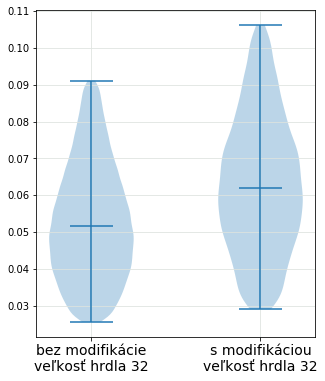

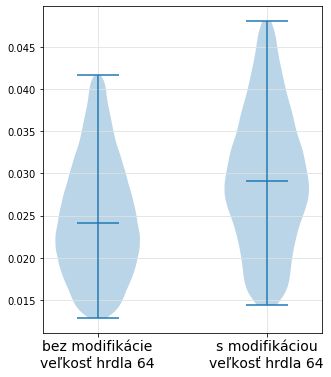

In [23]:
avg_mse_with32 = mses32[with_modif_in_middle].mean(1)
avg_mse_with64 = mses64[with_modif_in_middle].mean(1)
avg_mse_without32 = mses32[without_modif].mean(1)
avg_mse_without64 = mses64[without_modif].mean(1)

p_min_without64 = np.percentile(avg_mse_without64, 5)
p_max_without64 = np.percentile(avg_mse_without64, 95)
p_min_with64 = np.percentile(avg_mse_with64, 5)
p_max_with64 = np.percentile(avg_mse_with64, 95)
without64_avg = avg_mse_without64[(avg_mse_without64 > p_min_without64) 
                              & (avg_mse_without64 < p_max_without64)]
with64_avg = avg_mse_with64[(avg_mse_with64 > p_min_with64) 
                        & (avg_mse_with64 < p_max_with64)]


p_min_without32 = np.percentile(avg_mse_without32, 5)
p_max_without32 = np.percentile(avg_mse_without32, 95)
p_min_with32 = np.percentile(avg_mse_with32, 5)
p_max_with32 = np.percentile(avg_mse_with32, 95)
without32_avg = avg_mse_without32[(avg_mse_without32 > p_min_without32) 
                             & (avg_mse_without32 < p_max_without32)]
with32_avg = avg_mse_with32[(avg_mse_with32 > p_min_with32) 
                        & (avg_mse_with32 < p_max_with32)]

plt.figure(figsize=(5, 6))
plt.violinplot([without32_avg, with32_avg], showmedians=True,
               positions=[1, 2])
plt.xticks([1, 2],
           labels = ['bez modifikácie\nveľkosť hrdla 32', 
                     's modifikáciou\nveľkosť hrdla 32'],
          fontsize=14)
plt.grid(color='#dee3df')
# plt.savefig('violinplots_avg_1.png')
plt.show()
plt.figure(figsize=(5, 6))
plt.violinplot([without64_avg, with64_avg], showmedians=True,
               positions=[1, 2])
plt.xticks([1, 2],
           labels = ['bez modifikácie\nveľkosť hrdla 64', 
                     's modifikáciou\nveľkosť hrdla 64'],
          fontsize=14)
plt.grid(color='#dee3df')
# plt.savefig('violinplots_avg_2.png')
plt.show()



In [26]:
np.median(mses64[without_modif].mean(1)) / np.median(mses64[with_modif_in_middle].mean(1))

0.8306415792473171

In [27]:
median_rolled_mses_without32 = []
median_rolled_mses_with32 = []
median_rolled_mses_without64 = []
median_rolled_mses_with64 = []

for idx in tqdm(range(len(mses32))):
    if idx not in without_modif_set and idx not in with_modif_in_middle_set:
        continue
    if idx in without_modif_set:
        median_rolled_mses_without32.append(get_roll_mses(mses32[idx]))
        median_rolled_mses_without64.append(get_roll_mses(mses64[idx]))

    if idx in with_modif_in_middle_set:
        median_rolled_mses_with32.append(get_roll_mses(mses32[idx]))
        median_rolled_mses_with64.append(get_roll_mses(mses64[idx]))

avg_mse_with32 = mses32[with_modif_in_middle].mean(1)
avg_mse_with64 = mses64[with_modif_in_middle].mean(1)
avg_mse_without32 = mses32[without_modif].mean(1)
avg_mse_without64 = mses64[without_modif].mean(1)

median_rolled_mses_without32 = np.array(median_rolled_mses_without32)
median_rolled_mses_with32 = np.array(median_rolled_mses_with32)
avg_mse_without32 = np.array(avg_mse_without32)
avg_mse_with32 = np.array(avg_mse_with32)

median_rolled_mses_without64 = np.array(median_rolled_mses_without64)
median_rolled_mses_with64 = np.array(median_rolled_mses_with64)
avg_mse_without64 = np.array(avg_mse_without64)
avg_mse_with64 = np.array(avg_mse_with64)

with open("evaluation.npz", "wb") as f:
    np.savez(f, mses32, mses64, median_rolled_mses_without32, median_rolled_mses_with32, 
             avg_mse_without32, avg_mse_with32, median_rolled_mses_without64, 
             median_rolled_mses_with64)

  9%|▉         | 28020/320000 [13:07<2:16:49, 35.56it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-27-dc6f9821a1df>", line 10, in <module>
    median_rolled_mses_without32.append(get_roll_mses(mses32[idx]))
  File "<ipython-input-2-118840f34eb3>", line 24, in get_roll_mses
    roll_mses.append(np.median(mse))
  File "<__array_function__ internals>", line 6, in median
  File "/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py", line 3495, in median
    overwrite_input=overwrite_input)
  File "/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py", line 3403, in _ureduce
    r = func(a, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py", line 3528, in _median
    part = partition(a, kth, axis=axis)
  File "<__array_function__ internals>", line 6, in partition
  File "/usr/local/lib/python3.6/dist-packages/numpy/

KeyboardInterrupt: 

In [ ]:
max_mse_with32 = median_rolled_mses_with32.max(1)
max_mse_with64 = median_rolled_mses_with64.max(1)
max_mse_without32 = median_rolled_mses_without32.max(1)
max_mse_without64 = median_rolled_mses_without64.max(1)
max_mse_without64 *= 2.5
max_mse_with64 *= 2.5
p_min_without64 = np.percentile(max_mse_without64, 5)
p_max_without64 = np.percentile(max_mse_without64, 95)
p_min_with64 = np.percentile(max_mse_with64, 5)
p_max_with64 = np.percentile(max_mse_with64, 95)
without64_max = max_mse_without64[(max_mse_without64 > p_min_without64) 
                              & (max_mse_without64 < p_max_without64)]
with64_max = max_mse_with64[(max_mse_with64 > p_min_with64) 
                        & (max_mse_with64 < p_max_with64)]


p_min_without32 = np.percentile(max_mse_without32, 5)
p_max_without32 = np.percentile(max_mse_without32, 95)
p_min_with32 = np.percentile(max_mse_with32, 5)
p_max_with32 = np.percentile(max_mse_with32, 95)
without32_max = max_mse_without32[(max_mse_without32 > p_min_without32) 
                             & (max_mse_without32 < p_max_without32)]
with32_max = max_mse_with32[(max_mse_with32 > p_min_with32) 
                        & (max_mse_with32 < p_max_with32)]

plt.figure(figsize=(5, 6))
plt.violinplot([without32_max, with32_max], showmedians=True,
               positions=[1, 2])
plt.xticks([1, 2],
           labels = ['bez modifikácie\nveľkosť hrdla 32', 
                     's modifikáciou\nveľkosť hrdla 32'],
          fontsize=14)
plt.grid(color='#dee3df')
# plt.savefig('violinplots_max_1.png')
plt.show()
plt.figure(figsize=(5, 6))
plt.violinplot([without64_max, with64_max], showmedians=True,
               positions=[1, 2])
plt.xticks([1, 2],
           labels = ['bez modifikácie\nveľkosť hrdla 64', 
                     's modifikáciou\nveľkosť hrdla 64'],
          fontsize=14)
plt.grid(color='#dee3df')
# plt.savefig('violinplots_max_2.png')
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score
from matplotlib import pyplot as plt

In [ ]:
precisions = []
recalls = []
accuracies = []
avg_mse_with64 = mses64[with_modif_in_middle].mean(1) * 2
avg_mse_without64 = mses64[without_modif].mean(1) * 2
avg_mse64 = mses64.mean(1)
for thr in tqdm(np.linspace(np.min(avg_mse_with64), avg_mse_with64.max(), 300)):
    y_true = []
    y_pred = []
    for idx, mse in enumerate(avg_mse64):
        if idx not in without_modif_set and idx not in with_modif_in_middle_set:
            continue
        mse *= 2
        y_pred.extend([1 if mse > thr else 0 for i in [1]])
        y_true.extend([1 if idx in with_modif_in_middle_set else 0 for _ in [1]])
        
    w = precision_score(y_true, y_pred)
    precisions.append(w)
    recalls.append(recall_score(y_true, y_pred))
    accuracies.append(accuracy_score(y_true, y_pred))
print(recalls)

In [ ]:
np.max(accuracies) + len(with_modif_in_middle_set) / len(without_modif_set)

In [ ]:
np.max(precisions)

In [ ]:
# preds = model1.predict(X)
x = np.arange(X[29].flatten().shape[0])
plt.plot(x, X[29].flatten(), label="vstup")
plt.plot(x, preds64[29].flatten(), label="výstup")
plt.legend()
plt.show()

In [23]:
from fast5_research import Fast5
import numpy as np
from glob import glob
from config import test_seq_path, seq_path, corrected_group
from tqdm import tqdm
files_list = glob(test_seq_path)

In [62]:
leng = 0
num = 0
leng_events = 0
num_events = 0
is_not_okay = 0
fq_l = []
for filename in tqdm(files_list):
    try:
        with Fast5(filename) as fh:
            leng += len(fh.get_read(raw=True))
            t_path = f'Analyses/{corrected_group}/BaseCalled_template/Events/'
            c_path = f'Analyses/{corrected_group}/BaseCalled_complement/Events/'
            try:
                l_ = fh[c_path]['start'][-1] + fh[c_path]['length'][-1]
                l_ += (fh[t_path]['start'][-1] + fh[t_path]['length'][-1])
                num_events += len(fh[c_path]['start']) + len(fh[t_path]['start'])
                leng_events += l_
            except:
                is_not_okay += 1
            num += 1
    except OSError:
        print(filename)

  1%|          | 141/17219 [00:02<05:12, 54.72it/s]


In [44]:
fastq_tm = []
fastq_cm = []
corrupted = 0
for filename in tqdm(files_list):
    try:
        with Fast5(filename) as fh:
            read_id = f">{filename.split('/NB08/')[1]}\n"
            str_from_events_tm = "".join(np.array(fh['Analyses/RawGenomeCorrected_bwamem_000/BaseCalled_template/Events'])['base'].astype(str)) + '\n'
            str_from_events_cm = "".join(np.array(fh['Analyses/RawGenomeCorrected_bwamem_000/BaseCalled_complement/Events'])['base'].astype(str)) + '\n'
            if "makeson_PC_20160807_FNFAD20242_MN17284_sequencing_run_MA_470_R9_pUC_g_PCR_BC_08_07_16_93165_ch282_read509_strand.fast5" in read_id:
                break
#             fastq_tm.append(read_id)
#             fastq_tm.append(str_from_events_tm)
#             fastq_cm.append(read_id)
#             fastq_cm.append(str_from_events_cm)
    except:
        corrupted += 1
        if corrupted % 20 == 0:
            print(corrupted)

  4%|▍         | 745/17219 [00:07<02:35, 105.96it/s]


In [182]:
# with open("NB08_template.fasta", "w") as f:
#     f.writelines(fastq_tm)
# with open("NB08_complement.fasta", "w") as f:
#     f.writelines(fastq_cm)

In [124]:
# #pozicia v referencnom genome - pileupcolumn.pos 
# import json
# for strain in ['template', 'complement']:
#     samfile = pysam.AlignmentFile(f"/tf/NB08_{strain}_sorted.bam", "rb" )
#     red_ref_pos2read_pos = {}
#     read2ref_pos = defaultdict(set)
#     for pileupcolumn in tqdm(samfile.pileup()):
#         if pileupcolumn.pos not in methylsites: #alebo okolie? ako chces
#             continue        
#         read_names = pileupcolumn.get_query_names()
#         read_positions = pileupcolumn.get_query_positions() 
#         total_reads = len(read_positions)

#         for read, pos in zip(read_names, read_positions):
#             read2ref_pos[read].add(pileupcolumn.pos)
#             red_ref_pos2read_pos[(read, pileupcolumn.pos)] = pos
#             #najdi prisluchajuce okno centrovane na danu poziciu v tom reade
#             #...
#     samfile.close()
    
    
#     read2pos2ref_pos = {}
#     read2pos2ref_pos_v2 = {}
#     for r, ref_poss in read2ref_pos.items():
#         read2pos2ref_pos[r] = {}
#         for ref_pos in ref_poss:
#             read2pos2ref_pos[r][red_ref_pos2read_pos[r, ref_pos]] = ref_pos

            
#     for r, ref_poss in tqdm(read2ref_pos.items()):
#         try:
#             with Fast5(f"/tf/puc19/nanopore/MAP_Data/08_07_16_R9_pUC_BC/MA/downloads/pass/NB08/{r}") as fh:
#                 str_from_events = "".join(np.array(fh[f'Analyses/RawGenomeCorrected_bwamem_000/BaseCalled_{strain}/Events'])['base'].astype(str))
#                 seq = Seq(str_from_events)
#                 rev_cmp = str(seq.reverse_complement())
#             read2pos2ref_pos_v2[r] = {}
#             if str_from_events in ref_sequence:
#                 for ref_pos in ref_poss:
#                     read2pos2ref_pos_v2[r][red_ref_pos2read_pos[r, ref_pos]] = ref_pos
#             elif rev_cmp in ref_sequence:
#                 for ref_pos in ref_poss:
#                     read2pos2ref_pos_v2[r][len(str_from_events)-red_ref_pos2read_pos[r, ref_pos]-1] = ref_pos
#             else:
#                 print('e', end="")
#         except OSError:
#             corrupted += 1
#             if corrupted % 20 == 0:
#                 print(corrupted)           
#     with open(f"{strain}_map.json", "w") as f:
#         json.dump(read2pos2ref_pos_v2, f)

2686it [00:01, 1732.42it/s]
100%|██████████| 8613/8613 [00:51<00:00, 168.35it/s]
2686it [00:01, 1472.29it/s]
100%|██████████| 10561/10561 [00:59<00:00, 178.58it/s]


In [1]:
from Bio.Seq import Seq
import pysam
import re

In [2]:
with open("/tf/strain.fasta") as f:
    ref_seq = f.readlines()
ref_sequence = "".join(ref_seq[1:]).replace("\n", "")

In [198]:
methylsites = []
pos2type = {}
for motif in ["CCAGG", "CCTGG", "GATC"]:
    for ms in re.finditer(motif, ref_sequence):
        start = ms.start() + 1 
        methylsites.append(start)
        pos2type[start] = motif
methylsites = set(methylsites)

In [199]:
pos2type

{136: 'CCAGG',
 2400: 'CCAGG',
 327: 'CCTGG',
 2413: 'CCTGG',
 2534: 'CCTGG',
 264: 'GATC',
 405: 'GATC',
 990: 'GATC',
 1026: 'GATC',
 1043: 'GATC',
 1301: 'GATC',
 1347: 'GATC',
 1365: 'GATC',
 1706: 'GATC',
 1811: 'GATC',
 1823: 'GATC',
 1901: 'GATC',
 1909: 'GATC',
 1920: 'GATC',
 1995: 'GATC'}

In [200]:
from collections import defaultdict
from tqdm import tqdm
samfile.close()

In [352]:
strain2read2is_reverse = {}
strain2read2len = {}

for strain in ['template', 'complement']:
    samfile = pysam.AlignmentFile(f"/tf/NB08_{strain}_sorted.bam", "rb" )
    strain2read2is_reverse[strain] = {}
    strain2read2len[strain] = {}
    for read in samfile.fetch():
        strain2read2is_reverse[strain][read.query_name] = read.is_reverse
        strain2read2len[strain][read.query_name] = read.query_length
    samfile.close()

In [202]:
strain2read2is_reverse

{'template': {'makeson_PC_20160807_FNFAD20242_MN17284_sequencing_run_MA_470_R9_pUC_g_PCR_BC_08_07_16_93165_ch424_read1943_strand.fast5': False,
  'makeson_PC_20160807_FNFAD20242_MN17284_sequencing_run_MA_470_R9_pUC_g_PCR_BC_08_07_16_93165_ch102_read8025_strand.fast5': False,
  'makeson_PC_20160807_FNFAD20242_MN17284_sequencing_run_MA_470_R9_pUC_g_PCR_BC_08_07_16_93165_ch92_read3462_strand.fast5': False,
  'makeson_PC_20160807_FNFAD20242_MN17284_sequencing_run_MA_470_R9_pUC_g_PCR_BC_08_07_16_93165_ch334_read751_strand.fast5': False,
  'makeson_PC_20160807_FNFAD20242_MN17284_sequencing_run_MA_470_R9_pUC_g_PCR_BC_08_07_16_93165_ch492_read7824_strand.fast5': False,
  'makeson_PC_20160807_FNFAD20242_MN17284_sequencing_run_MA_470_R9_pUC_g_PCR_BC_08_07_16_93165_ch235_read1441_strand1.fast5': False,
  'makeson_PC_20160807_FNFAD20242_MN17284_sequencing_run_MA_470_R9_pUC_g_PCR_BC_08_07_16_93165_ch402_read3917_strand.fast5': False,
  'makeson_PC_20160807_FNFAD20242_MN17284_sequencing_run_MA_470_R

In [384]:
#pozicia v referencnom genome - pileupcolumn.pos 
import json
for strain in ['template', 'complement']:
    read2is_reverse = strain2read2is_reverse[strain]
    read2len = strain2read2len[strain]
    samfile = pysam.AlignmentFile(f"/tf/NB08_{strain}_sorted.bam", "rb" )
    red_ref_pos2read_pos = {}
    read2ref_pos = defaultdict(set)
    for pileupcolumn in tqdm(samfile.pileup()):
#         if pileupcolumn.pos not in methylsites: #alebo okolie? ako chces
#             continue        
        read_names = pileupcolumn.get_query_names()
        read_positions = pileupcolumn.get_query_positions() 
        total_reads = len(read_positions)

        for read, pos in zip(read_names, read_positions):
            read2ref_pos[read].add(pileupcolumn.pos)
            red_ref_pos2read_pos[(read, pileupcolumn.pos)] = pos
    samfile.close()
    read2pos2ref_pos = {}
    for r, ref_poss in read2ref_pos.items():
        read2pos2ref_pos[r] = {}
        for ref_pos in ref_poss:
            if read2is_reverse[r]:
#                 if pos2type[ref_pos] == "GATC":
                read2pos2ref_pos[r][read2len[r]-red_ref_pos2read_pos[r, ref_pos]-1] = -1*ref_pos
#                 else pos2type[ref_pos] != "GATC":
#                     read2pos2ref_pos[r][read2len[r]-red_ref_pos2read_pos[r, ref_pos]-1] = -1*ref_pos
            elif not read2is_reverse[r]:
                read2pos2ref_pos[r][red_ref_pos2read_pos[r, ref_pos]] = ref_pos
    with open(f"{strain}_map_2.json", "w") as f:
        json.dump(read2pos2ref_pos, f)

2686it [01:24, 31.96it/s] 
2686it [01:32, 28.98it/s]


In [385]:
len(read2pos2ref_pos)

10688

In [398]:
read2pos2ref_pos[r][13]

-2669

In [399]:
str_from_events

'TATTGAAAAAGGAAGAGTATGAGTATTCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGGCATTTTGCCTTCCTGTTTTTGCTCACCCAGAAACGCTGGTGAAAGTAAAAGATGCTGAAGATCAGTTGGGTGCACGAGTGGGTTACATCGAACTGGATCTCAACAGCGGTAAGATCCTTGAGAGTTTTCGCCCCGAAGAACGTTTTCCAATGATGAGCACTTTTAAAGTTCTGCTATGTGGCGCGGTATTATCCCGTATTGACGCCGGGCAAGAGCAACTCGGTCGCCGCATACACTATTCTCAGAATGACTTGGTTGAGTACTCACCAGTCACAGAAAAGCATCTTACGGATGGCATGACAGTAAGAGAATTATGCAGTGCTGCCATAACCATGAGTGATAACACTGCGGCCAACTTACTTCTGACAACGATCGGAGGACCGAAGGAGCTAACCGCTTTTTTGCACAACATGGGGGATCATGTAACTCGCCTTGATCGTTGGGAACCGGAGCTGAATGAAGCCATACCAAACGACGAGCGTGACACCACGATGCCTGTAGCAATGGCAACAACGTTGCGCAAACTATTAACTGGCGAACTACTTACTCTAGCTTCCCGGCAACAATTAATAGACTGGATGGAGGCGGATAAAGTTGCAGGACCACTTCTGCGCTCGGCCCTTCCGGCTGGCTGGTTTATTGCTGATAAATCTGGAGCCGGTGAGCGTGGGTCTCGCGGTATCATTGCAGCACTGGGGCCAGATGGTAAGCCCTCCCGTATCGTAGTTATCTACACGACGGGGAGTCAGGCAACTATGGATGAACGAAATAGACAGATCGCTGAGATAGGTGCCTCACTGATTAAGCATTGGTAACTGTCAGACCAAGTTTACTCATATATACTTTAGATTGATTTAAAACTTCATTTTTAATTTAAAAGGATCTAGGTGAAGATCCTTTTTGATAATCTCATGACCAAAATCCCTTAACGTGAG

In [386]:
with open(f"template_map_2.json", "r") as f:
    t_map = json.load(f)
with open(f"complement_map_2.json", "r") as f:
    c_map = json.load(f)

In [388]:
len(c_map)

10688

In [404]:
t_map[r]


{'0': 866,
 '1': 867,
 '2': 868,
 '3': 869,
 '4': 870,
 '5': 871,
 '6': 872,
 '7': 873,
 '8': 874,
 '9': 875,
 '10': 876,
 '11': 877,
 '12': 878,
 '13': 879,
 '14': 880,
 '15': 881,
 '16': 882,
 '17': 883,
 '18': 884,
 '19': 885,
 '20': 886,
 '21': 887,
 '22': 888,
 '23': 889,
 '24': 890,
 '25': 891,
 '26': 892,
 '27': 893,
 '28': 894,
 '29': 895,
 '30': 896,
 '31': 897,
 '32': 898,
 '33': 899,
 '34': 900,
 '35': 901,
 '36': 902,
 '37': 903,
 '38': 904,
 '39': 905,
 '40': 906,
 '41': 907,
 '42': 908,
 '43': 909,
 '44': 910,
 '45': 911,
 '46': 912,
 '47': 913,
 '48': 914,
 '49': 915,
 '50': 916,
 '51': 917,
 '52': 918,
 '53': 919,
 '54': 920,
 '55': 921,
 '56': 922,
 '57': 923,
 '58': 924,
 '59': 925,
 '60': 926,
 '61': 927,
 '62': 928,
 '63': 929,
 '64': 930,
 '65': 931,
 '66': 932,
 '67': 933,
 '68': 934,
 '69': 935,
 '70': 936,
 '71': 937,
 '72': 938,
 '73': 939,
 '74': 940,
 '75': 941,
 '76': 942,
 '77': 943,
 '78': 944,
 '79': 945,
 '80': 946,
 '81': 947,
 '82': 948,
 '83': 949,
 '

In [405]:
r = 'makeson_PC_20160807_FNFAD20242_MN17284_sequencing_run_MA_470_R9_pUC_g_PCR_BC_08_07_16_93165_ch385_read1713_strand.fast5'
with Fast5(f"/tf/puc19/nanopore/MAP_Data/08_07_16_R9_pUC_BC/MA/downloads/pass/NB08/{r}") as fh:
    str_from_events = "".join(np.array(fh[f'Analyses/RawGenomeCorrected_bwamem_000/BaseCalled_template/Events'])['base'].astype(str))

In [409]:
str_from_events[110:200]

'AAAAGATGCTGAAGATCAGTTGGGTGCACGAGTGGGTTACATCGAACTGGATCTCAACAGCGGTAAGATCCTTGAGAGTTTTCGCCCCGA'

In [363]:
read2len[r]

1823

In [362]:
len(str_from_events)

1823

In [364]:
str_from_events

'TCCGCTTCCTCGCTCACTGACTCGCTGCGCTCGGTCGTTCGGCTGCGGCGAGCGGTATCAGCTCACTCAAAGGCGGTAATACGGTTATCCACAGAATCAGGGGATAACGCAGGAAAGAACATGTGAGCAAAAGGCCAGCAAAAGGCCAGGAACCGTAAAAAGGCCGCGTTGCTGGCGTTTTTCCATAGGCTCCGCCCCCCTGACGAGCATCACAAAAATCGACGCTCAAGTCAGAGGTGGCGAAACCCGACAGGACTATAAAGATACCAGGCGTTTCCCCCTGGAAGCTCCCTCGTGCGCTCTCCTGTTCCGACCCTGCCGCTTACCGGATACCTGTCCGCCTTTCTCCCTTCGGGAAGCGTGGCGCTTTCTCATAGCTCACGCTGTAGGTATCTCAGTTCGGTGTAGGTCGTTCGCTCCAAGCTGGGCTGTGTGCACGAACCCCCCGTTCAGCCCGACCGCTGCGCCTTATCCGGTAACTATCGTCTTGAGTCCAACCCGGTAAGACACGACTTATCGCCACTGGCAGCAGCCACTGGTAACAGGATTAGCAGAGCGAGGTATGTAGGCGGTGCTACAGAGTTCTTGAAGTGGTGGCCTAACTACGGCTACACTAGAAGAACAGTATTTGGTATCTGCGCTCTGCTGAAGCCAGTTACCTTCGGAAAAAGAGTTGGTAGCTCTTGATCCGGCAAACAAACCACCGCTGGTAGCGGTGGTTTTTTTGTTTGCAAGCAGCAGATTACGCGCAGAAAAAAAGGATCTCAAGAAGATCCTTTGATCTTTTCTACGGGGTCTGACGCTCAGTGGAACGAAAACTCACGTTAAGGGATTTTGGTCATGAGATTATCAAAAAGGATCTTCACCTAGATCCTTTTAAATTAAAAATGAAGTTTTAAATCAATCTAAAGTATATATGAGTAAACTTGGTCTGACAGTTACCAATGCTTAATCAGTGAGGCACCTATCTCAGCGATCTGTCTATTTCGTTCATCCATA

In [365]:
read2pos2ref_pos[r]

{761: 1921,
 280: 2402,
 1655: 1027,
 1334: 1348,
 146: 2536,
 975: 1707,
 686: 1996,
 780: 1902,
 267: 2415,
 1638: 1044,
 870: 1812,
 1380: 1302,
 1316: 1366,
 772: 1910,
 1691: 991,
 858: 1824}

In [293]:
pos2type

{136: 'CCAGG',
 2400: 'CCAGG',
 327: 'CCTGG',
 2413: 'CCTGG',
 2534: 'CCTGG',
 264: 'GATC',
 405: 'GATC',
 990: 'GATC',
 1026: 'GATC',
 1043: 'GATC',
 1301: 'GATC',
 1347: 'GATC',
 1365: 'GATC',
 1706: 'GATC',
 1811: 'GATC',
 1823: 'GATC',
 1901: 'GATC',
 1909: 'GATC',
 1920: 'GATC',
 1995: 'GATC'}

In [269]:
bool(strain2read2is_reverse['complement'][r])

True

In [296]:
set(read2pos2ref_pos[r].values()).intersection(set(pos2type.keys()))

set()

In [151]:
read2pos2ref_pos_v2[r].keys()

dict_keys([762, 282, 1656, 1335, 148, 976, 687, 781, 269, 1639, 871, 1381, 1317, 773, 1692, 859])

In [138]:
np.array(list(str_from_events))[list(read2pos2ref_pos_v2[r].keys())]

array(['T', 'G', 'T', 'T', 'G', 'T', 'T', 'T', 'G', 'T', 'T', 'T', 'T',
       'T', 'T', 'T'], dtype='<U1')

In [134]:
np.array(list(ref_sequence))[list(read2pos2ref_pos_v2[r].values())]

array(['A', 'C', 'A', 'A', 'C', 'A', 'A', 'A', 'C', 'A', 'A', 'A', 'A',
       'A', 'A', 'A'], dtype='<U1')

In [156]:
read2pos2ref_pos_v2[r][148]

2534

In [46]:
print(read_id)
r = read_id[1:-1]
r

>makeson_PC_20160807_FNFAD20242_MN17284_sequencing_run_MA_470_R9_pUC_g_PCR_BC_08_07_16_93165_ch282_read509_strand.fast5



'makeson_PC_20160807_FNFAD20242_MN17284_sequencing_run_MA_470_R9_pUC_g_PCR_BC_08_07_16_93165_ch282_read509_strand.fast5'

In [109]:
for i, ch in enumerate(str_from_events_tm):
    if i > k-2 and i < k+2:
        print(i, k, ch)
ref_sequence[x]

326 327 T
327 327 A
328 327 C


'C'

In [146]:
seq = Seq("GACTCTAGAGGATCCCCGGGTACCGAGC")
rev_ref = str(seq.reverse_complement())

In [305]:
ref_sequence

'GCGCCCAATACGCAAACCGCCTCTCCCCGCGCGTTGGCCGATTCATTAATGCAGCTGGCACGACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGGAATTGTGAGCGGATAACAATTTCACACAGGAAACAGCTATGACCATGATTACGCCAAGCTTGCATGCCTGCAGGTCGACTCTAGAGGATCCCCGGGTACCGAGCTCGAATTCACTGGCCGTCGTTTTACAACGTCGTGACTGGGAAAACCCTGGCGTTACCCAACTTAATCGCCTTGCAGCACATCCCCCTTTCGCCAGCTGGCGTAATAGCGAAGAGGCCCGCACCGATCGCCCTTCCCAACAGTTGCGCAGCCTGAATGGCGAATGGCGCCTGATGCGGTATTTTCTCCTTACGCATCTGTGCGGTATTTCACACCGCATATGGTGCACTCTCAGTACAATCTGCTCTGATGCCGCATAGTTAAGCCAGCCCCGACACCCGCCAACACCCGCTGACGCGCCCTGACGGGCTTGTCTGCTCCCGGCATCCGCTTACAGACAAGCTGTGACCGTCTCCGGGAGCTGCATGTGTCAGAGGTTTTCACCGTCATCACCGAAACGCGCGAGACGAAAGGGCCTCGTGATACGCCTATTTTTATAGGTTAATGTCATGATAATAATGGTTTCTTAGACGTCAGGTGGCACTTTTCGGGGAAATGTGCGCGGAACCCCTATTTGTTTATTTTTCTAAATACATTCAAATATGTATCCGCTCATGAGACAATAACCCTGATAAATGCTTCAATAATATTGAAAAAGGAAGAGTATGAGTATTCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGGCATTTTGCCTTCCTGTTTTTGCTCACCCAGAAACGCTGGTGAAAGTAAAAGATGCTGAAGATCAGTTGG

In [160]:
# ref_sequence[2532:2538]
str_from_events[148]

'G'

In [122]:

seq = Seq(str_from_events_cm)
rev_cmp = str(seq.reverse_complement())
rev_cmp_2 = str_from_events_cm[::-1]

for i, (fname, v) in enumerate(read2pos2ref_pos_v2.items()):
    with Fast5(f'/tf/puc19/nanopore/MAP_Data/08_07_16_R9_pUC_BC/MA/downloads/pass/NB08/{fname}') as fh:
        str_from_events_tm = "".join(np.array(fh['Analyses/RawGenomeCorrected_bwamem_000/BaseCalled_template/Events'])['base'].astype(str)) + '\n'
#         str_from_events_cm = "".join(np.array(fh['Analyses/RawGenomeCorrected_bwamem_000/BaseCalled_complement/Events'])['base'].astype(str)) + '\n'
    for k, x in v.items():
        if str_from_events_tm[k] != ref_sequence[x]:
            print(k, str_from_events_tm[k], ref_sequence[x], x)
#     if i > 20:
#         break
    #     assert rev_cmp[k] == ref_sequence[v]

725 G C 136
597 T A 264
456 T A 405
534 G C 327
731 G C 136
603 T A 264
462 T A 405
540 G C 327
725 G C 136
597 T A 264
456 T A 405
534 G C 327
728 G C 136
600 T A 264
459 T A 405
537 G C 327
722 G C 136
594 T A 264
453 T A 405
531 G C 327
731 G C 136
603 T A 264
462 T A 405
540 G C 327
728 G C 136
600 T A 264
459 T A 405
537 G C 327
744 G C 136
616 T A 264
475 T A 405
553 G C 327
731 G C 136
603 T A 264
462 T A 405
540 G C 327
728 G C 136
600 T A 264
459 T A 405
537 G C 327
725 G C 136
597 T A 264
456 T A 405
534 G C 327
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
2358 G C 327
2549 G C 136
2421 T A 264
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
2280 T A 405
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
731 G C 136
603 T A 264
462 T A 405
540 G C 327
724 G C 136
596 T A 264
455 T A 405
533 G C 327
731 G C 136
603 T A 264
462 T A 405
540 G C 327
728 G C 136
600 T A 264
459 T A 405
537 G C 327
731 G C 136
603

765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
764 T A 1920
284 G C 2400
1658 T A 1026
1337 T A 1347
150 G C 2534
978 T A 1706
689 T A 1995
783 T A 1901
271 G C 2413
1641 T A 1043
873 T A 1811
13

862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
764 T A 1920
284 G C 2400
1658 T A 1026
1337 T A 1347
150 G C 2534
978 T A 1706
689 T A 1995
783 T A 1901
271 G C 2413
1641 T A 1043
873 T A 1811
1383 T A 1301
1319 T A 1365
775 T A 1909
1694 T A 990
861 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
764 T A 1920
284 G C 2400
1658 T A 1026
1337 T A 1347
150 G C 2534
978 T A 1706
689 T A 1995
783 T A 1901
271 G C 2413
1641 T A 1043
87

765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
757 T A 1920
277 G C 2400
1651 T A 1026
1330 T A 1347
143 G C 2534
971 T A 1706
682 T A 1995
776 T A 1901
264 G C 2413
1634 T A 1043
866 T A 1811
13

764 T A 1920
284 G C 2400
1658 T A 1026
1337 T A 1347
150 G C 2534
978 T A 1706
689 T A 1995
783 T A 1901
271 G C 2413
1641 T A 1043
873 T A 1811
1383 T A 1301
1319 T A 1365
775 T A 1909
1694 T A 990
861 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
755 T A 1920
275 G C 2400
1649 T A 1026
1328 T A 1347
141 G C 2534
969 T A 1706
680 T A 1995
774 T A 1901
262 G C 2413
1632 T A 1043
864 T A 1811
1374 T A 1301
1310 T A 1365
766 T A 1909
1685 T A 990
852 T A 1823
758 T A 1920
278 G C 2400
1652 T A 1026
1331 T A 1347
144 G C 2534
972 T A 1706
683 T A 1995
777 T A 1901
265 G C 2413
1635 T A 1043
867 T A 1811
1377 T A 1301
1313 T A 1365
769 T A 1909
1688 T A 990
855 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
13

765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
760 T A 1920
280 G C 2400
1654 T A 1026
1333 T A 1347
146 G C 2534
974 T A 1706
685 T A 1995
779 T A 1901
267 G C 2413
1637 T A 1043
869 T A 1811
1379 T A 1301
1315 T A 1365
771 T A 1909
1690 T A 990
857 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
13

272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
758 T A 1920
278 G C 2400
1652 T A 1026
1331 T A 1347
144 G C 2534
972 T A 1706
683 T A 1995
777 T A 1901
265 G C 2413
1635 T A 1043
867 T A 1811
1377 T A 1301
1313 T A 1365
769 T A 1909
1688 T A 990
855 T A 1823
735 T A 1920
255 G C 2400
1629 T A 1026
1308 T A 1347
121 G C 2534
949 T A 1706
660 T A 1995
754 T A 1901
242 G C 2413
1612 T A 1043
844 T A 1811
1354 T A 1301
1290 T A 1365
746 T A 1909
1665 T A 990
832 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
760 T A 1920
280 G C 2400
1654 T A 1026
1

765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
13

1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
758 T A 1920
278 G C 2400
1652 T A 1026
1331 T A 1347
144 G C 2534
972 T A 1706
683 T A 1995
777 T A 1901
265 G C 2413
1635 T A 1043
867 T A 1811
1377 T A 1301
1313 T A 1365
769 T A 1909
1688 T A 990
855 T A 1823
758 T A 1920
278 G C 2400
1652 T A 1026
1331 T A 1347
144 G C 2534
972 T A 1706
683 T A 1995
777 T A 1901
265 G C 2413
1635 T A 1043
867 T A 1811
1377 T A 1301
1313 T A 1365
769 T A 1909
1688 T A 990
855 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347


781 T A 1901
269 G C 2413
1639 T A 1043
871 T A 1811
1381 T A 1301
1317 T A 1365
773 T A 1909
1692 T A 990
859 T A 1823
762 T A 1920
282 G C 2400
1656 T A 1026
1335 T A 1347
148 G C 2534
976 T A 1706
687 T A 1995
781 T A 1901
269 G C 2413
1639 T A 1043
871 T A 1811
1381 T A 1301
1317 T A 1365
773 T A 1909
1692 T A 990
859 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
16

738 T A 1920
258 G C 2400
1632 T A 1026
1311 T A 1347
124 G C 2534
952 T A 1706
663 T A 1995
757 T A 1901
245 G C 2413
1615 T A 1043
847 T A 1811
1357 T A 1301
1293 T A 1365
749 T A 1909
1668 T A 990
835 T A 1823
749 T A 1920
269 G C 2400
1643 T A 1026
1322 T A 1347
135 G C 2534
963 T A 1706
674 T A 1995
768 T A 1901
256 G C 2413
1626 T A 1043
858 T A 1811
1368 T A 1301
1304 T A 1365
760 T A 1909
1679 T A 990
846 T A 1823
758 T A 1920
278 G C 2400
1652 T A 1026
1331 T A 1347
144 G C 2534
972 T A 1706
683 T A 1995
777 T A 1901
265 G C 2413
1635 T A 1043
867 T A 1811
1377 T A 1301
1313 T A 1365
769 T A 1909
1688 T A 990
855 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
13

1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
762 T A 1920
282 G C 2400
1656 T A 1026
1335 T A 1347
148 G C 2534
976 T A 1706
687 T A 1995
781 T A 1901
269 G C 2413
1639 T A 1043
871 T A 1811
1381 T A 1301
1317 T A 1365
773 T A 1909
1692 T A 990
859 T A 1823
764 T A 1920
284 G C 2400
1658 T A 1026
1337 T A 1347
150 G C 2534
978 T A 1706
689 T A 1995
783 T A 1901
271 G C 2413
1641 T A 1043
873 T A 1811
1383 T A 1301
1319 T A 1365
775 T A 1909
1694 T A 990
861 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
164

765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
761 T A 1920
281 G C 2400
1655 T A 1026
1334 T A 1347
147 G C 2534
975 T A 1706
686 T A 1995
780 T A 1901
268 G C 2413
1638 T A 1043
870 T A 1811
1380 T A 1301
1316 T A 1365
772 T A 1909
1691 T A 990
858 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
754 T A 1920
274 G C 2400
1648 T A 1026
1327 T A 1347
140 G C 2534
968 T A 1706
679 T A 1995
773 T A 1901
261 G C 2413
1631 T A 1043
863 T A 1811
13

765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
755 T A 1920
275 G C 2400
1649 T A 1026
1328 T A 1347
141 G C 2534
969 T A 1706
680 T A 1995
774 T A 1901
262 G C 2413
1632 T A 1043
864 T A 1811
13

765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
760 T A 1920
280 G C 2400
1654 T A 1026
1333 T A 1347
146 G C 2534
974 T A 1706
685 T A 1995
779 T A 1901
267 G C 2413
1637 T A 1043
869 T A 1811
1379 T A 1301
1315 T A 1365
771 T A 1909
1690 T A 990
857 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
758 T A 1920
278 G C 2400
1652 T A 1026
1331 T A 1347
144 G C 2534
972 T A 1706
683 T A 1995
777 T A 1901
265 G C 2413
1635 T A 1043
867 T A 1811
13

765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
13

874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
764 T A 1920
284 G C 2400
1658 T A 1026
1337 T A 1347
150 G C 2534
978 T A 1706
689 T A 1995
783 T A 1901
271 G C 2413
1641 T A 1043
873 T A 1811
1383 T A 1301
1319 T A 1365
775 T A 1909
1694 T A 990
861 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
9

765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
13

765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
13

765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
758 T A 1920
278 G C 2400
1652 T A 1026
1331 T A 1347
144 G C 2534
972 T A 1706
683 T A 1995
777 T A 1901
265 G C 2413
1635 T A 1043
867 T A 1811
1377 T A 1301
1313 T A 1365
769 T A 1909
1688 T A 990
855 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
13

1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
762 T A 1920
282 G C 2400
1656 T A 1026
1335 T A 1347
148 G C 2534
976 T A 1706
687 T A 1995
781 T A 1901
269 G C 2413
1639 T A 1043
871 T A 1811
1381 T A 1301
1317 T A 1365
773 T A 1909
1692 T A 990
859 T A 1823
754 T A 1920
274 G C 2400
1648 T A 1026
1327 T A 1347
140 G C 2534
968 T A 1706
679 T A 1995
773 T A 1901
261 G C 2413
1631 T A 1043
863 T A 1811
1373 T A 1301
1309 T A 1365
765 T A 1909
1684 T A 990
851 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347


272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
634 T A 1920
154 G C 2400
1528 T A 1026
1207 T A 1347
20 G C 2534
848 T A 1706
559 T A 1995
653 T A 1901
141 G C 2413
1511 T A 1043
743 T A 1811
1253 T A 1301
1189 T A 1365
645 T A 1909
1564 T A 990
731 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
13

765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
13

1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
760 T A 1920
280 G C 2400
1654 T A 1026
1333 T A 1347
146 G C 2534
974 T A 1706
685 T A 1995
779 T A 1901
267 G C 2413
1637 T A 1043
869 T A 1811
1379 T A 1301
1315 T A 1365
771 T A 1909
1690 T A 990
857 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347
151 G C 2534
979 T A 1706
690 T A 1995
784 T A 1901
272 G C 2413
1642 T A 1043
874 T A 1811
1384 T A 1301
1320 T A 1365
776 T A 1909
1695 T A 990
862 T A 1823
765 T A 1920
285 G C 2400
1659 T A 1026
1338 T A 1347


KeyboardInterrupt: 

In [368]:
list(read2ref_pos.keys())[:10]

['makeson_PC_20160807_FNFAD20242_MN17284_sequencing_run_MA_470_R9_pUC_g_PCR_BC_08_07_16_93165_ch64_read570_strand.fast5',
 'makeson_PC_20160807_FNFAD20242_MN17284_sequencing_run_MA_470_R9_pUC_g_PCR_BC_08_07_16_93165_ch282_read509_strand.fast5',
 'makeson_PC_20160807_FNFAD20242_MN17284_sequencing_run_MA_470_R9_pUC_g_PCR_BC_08_07_16_93165_ch28_read337_strand.fast5',
 'makeson_PC_20160807_FNFAD20242_MN17284_sequencing_run_MA_470_R9_pUC_g_PCR_BC_08_07_16_93165_ch201_read5322_strand.fast5',
 'makeson_PC_20160807_FNFAD20242_MN17284_sequencing_run_MA_470_R9_pUC_g_PCR_BC_08_07_16_93165_ch478_read51275_strand.fast5',
 'makeson_PC_20160807_FNFAD20242_MN17284_sequencing_run_MA_470_R9_pUC_g_PCR_BC_08_07_16_93165_ch261_read5891_strand.fast5',
 'makeson_PC_20160807_FNFAD20242_MN17284_sequencing_run_MA_470_R9_pUC_g_PCR_BC_08_07_16_93165_ch437_read1219_strand.fast5',
 'makeson_PC_20160807_FNFAD20242_MN17284_sequencing_run_MA_470_R9_pUC_g_PCR_BC_08_07_16_93165_ch130_read2649_strand.fast5',
 'makeson_PC

In [357]:
read2ref_pos[r]

{136, 264, 327, 405}

In [358]:
for ix in [136, 264, 327, 405]:
    print(red_ref_pos2read_pos[(r, ix)], end = ", ")

136, 264, 327, 405, 

In [359]:
np.array(list(ref_sequence))[[136, 264, 327, 405]]

array(['C', 'A', 'C', 'A'], dtype='<U1')

In [366]:
np.array(list(str_from_events_cm))[[136, 264, 327, 405]]

array(['C', 'A', 'C', 'A'], dtype='<U1')

In [364]:
seq = Seq(str_from_events_cm)
rev_cmp = str(seq.reverse_complement())[1:]
np.array(list(rev_cmp))[[136, 264, 327, 405]]

'TATTATTGAAGCATTTATCAGGGTTATTGTCTCATGAGCGGATACATATTTGAATGTATTTAGAAAAATAAACAAATAGGGGTTCCGCGCACATTTCCCCGAAAAGTGCCACCTGACGTCTAAGAAACCATTATTATCATGACATTAACCTATAAAAATAGGCGTATCACGAGGCCCTTTCGTCTCGCGCGTTTCGGTGATGACGGTGAAAACCTCTGACACATGCAGCTCCCGGAGACGGTCACAGCTTGTCTGTAAGCGGATGCCGGGAGCAGACAAGCCCGTCAGGGCGCGTCAGCGGGTGTTGGCGGGTGTCGGGGCTGGCTTAACTATGCGGCATCAGAGCAGATTGTACTGAGAGTGCACCATATGCGGTGTGAAATACCGCACAGATGCGTAAGGAGAAAATACCGCATCAGGCGCCATTCGCCATTCAGGCTGCGCAACTGTTGGGAAGGGCGATCGGTGCGGGCCTCTTCGCTATTACGCCAGCTGGCGAAAGGGGGATGTGCTGCAAGGCGATTAAGTTGGGTAACGCCAGGGTTTTCCCAGTCACGACGTTGTAAAACGACGGCCAGTGAATTCGAGCTCGGTACCCGGGGATCCTCTAGAGTCGACCTGCAGGCATGCAAGCTTGGCGTAATCATGGTCATAGCTGTTTCCTGTGTGAAATTGTTATCCGCTCACAATTCCACACAACATACGAGCCGGAAGCATAAAGTGTAAAGCCTGGGGTGCCTAATGAGTGAGCTAACTCACATTAATTGCGTTGCGCTCACTGCCCGCTTTCCAGTCGGGAAACCTGTCGTGCCAGCTGCATTAATGAATCGGCCAACGCGCGGGGAGAGGCGGTTTGCGTATTGGGCGC'

In [5]:
is_not_okay

4

In [6]:
avg_read_len = leng/num

In [7]:
num_events

1495987

In [8]:
avg_num_events_in_read = num_events/(num-is_not_okay)
avg_num_events_in_read

3252.145652173913

In [9]:
avg_signal_per_event = leng_events / num_events
avg_signal_per_event

15.15662836642297

In [10]:
avg_read_len

92965.05818965517